# Naive Bayes Spam Detection

This notebook walks us through building a spam detection system using the Naive Bayes algorithm. By the end, we will see how the algorithm works with a real-world dataset to classify emails as spam or not.


## Exercise Statement: SPAM Detection

We propose the construction of a machine learning system capable of predicting whether a given email corresponds to **SPAM** or not. For this, the following dataset will be used:

#### [2007 TREC Public Spam Corpus](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo07)
The trec07p corpus contains 75,419 messages:

- 25,220 ham
- 50,199 spam

These messages constitute all the messages delivered to a particular server between these dates:

- Sun, 8 Apr 2007 13:07:21 -0400
- Fri, 6 Jul 2007 07:04:53 -0400

If the previous link doesn’t work, please try accessing the dataset [here](https://drive.google.com/file/d/1kFA669INPYyYYUFA8Kqd7GStbHksQLJS/view?usp=drive_link).


## 1. Preprocessing Emails and Auxiliary Functions

Spam detection requires some heavy lifting when it comes to cleaning up data. Emails can be messy—think HTML tags, special characters, and extra text that doesn't help with classification. 

HTML Stripper: This function removes any HTML tags, leaving us with just the text content.
Parser Class: This class does most of the work:
It decodes email subjects and bodies
It tokenizes (splits text into words), removes punctuation, and applies stemming (converting words to their base form).

In [76]:

# This class facilitates preprocessing emails that contain HTML code
from html import unescape
from html.parser import HTMLParser

class HTMLStripper(HTMLParser):
    def __init__(self):
        super().__init__(convert_charrefs=True)
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)



In [77]:
# This function removes HTML tags found in the email text
def strip_tags(html):
    s = HTMLStripper()
    s.feed(html)
    return s.get_data()


In [78]:
# Example of removing HTML tags from text
t = '<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>'
print(strip_tags(t))


Phrack World News


Besides removing possible HTML tags found in the email, other preprocessing actions need to be performed
to avoid unnecessary noise in the messages. Among them is the removal of punctuation marks,
removal of possible irrelevant email fields, or removal of word affixes keeping only the root of the word (Stemming).
The class shown below performs these transformations.

In [79]:
import os
import email
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from email.header import decode_header

class Parser:

    def __init__(self):
        self.stemmer = PorterStemmer()
        nltk.download('stopwords', quiet=True)
        self.stopwords = set(stopwords.words('english'))
        self.punctuation = set(string.punctuation)

    def parse(self, email_path):
        """Parse an email."""
        with open(email_path, 'rb') as e:
            msg = email.message_from_binary_file(e)
        return self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract the email content."""
        subject = self.get_subject(msg)
        body = self.get_email_body(msg)
        return {"subject": subject,
                "body": body,
                "content_type": msg.get_content_type()}

    def get_subject(self, msg):
        """Decode the email subject."""
        if msg['Subject']:
            decoded_header = decode_header(msg['Subject'])
            subject = ''
            for part, encoding in decoded_header:
                if isinstance(part, bytes):
                    if not encoding or encoding.lower() in ['unknown-8bit', 'unknown', 'x-unknown']:
                        encoding = 'utf-8'
                    try:
                        part = part.decode(encoding, errors='ignore')
                    except (LookupError, UnicodeDecodeError):
                        # Fallback encodings
                        for enc in ['utf-8', 'latin1', 'ascii']:
                            try:
                                part = part.decode(enc, errors='ignore')
                                break
                            except UnicodeDecodeError:
                                continue
                elif isinstance(part, str):
                    pass  # part is already a string
                subject += part
            return self.tokenize(subject)
        else:
            return []

    def get_email_body(self, msg):
        """Extract the body of the email."""
        body = []
        if msg.is_multipart():
            for part in msg.get_payload():
                body += self.get_email_body(part)
        else:
            content_type = msg.get_content_type()
            payload = msg.get_payload(decode=True)
            if payload:
                charset = msg.get_content_charset()
                # Handle unknown or problematic charsets
                if not charset or charset.lower() in ['unknown-8bit', 'unknown', 'x-unknown']:
                    charset = 'utf-8'
                try:
                    payload = payload.decode(charset, errors='ignore')
                except (LookupError, UnicodeDecodeError):
                    # Fallback encodings
                    for enc in ['utf-8', 'latin1', 'ascii']:
                        try:
                            payload = payload.decode(enc, errors='ignore')
                            break
                        except UnicodeDecodeError:
                            continue
                if content_type == 'text/plain':
                    body += self.tokenize(payload)
                elif content_type == 'text/html':
                    body += self.tokenize(strip_tags(payload))
        return body

    def tokenize(self, text):
        """Transform a text string into tokens."""
        text = text.lower()
        for c in self.punctuation:
            text = text.replace(c, "")
        tokens = text.split()
        tokens = [w for w in tokens if w not in self.stopwords]
        return [self.stemmer.stem(w) for w in tokens]


In [80]:
# Set the dataset path
DATASET_PATH = "datasets/trec07p"

# Read the index
index_path = os.path.join(DATASET_PATH, 'full', 'index')
with open(index_path, 'r') as f:
    index = f.readlines()
print(index[:5])  # Print first 5 entries


['spam ../data/inmail.1\n', 'ham ../data/inmail.2\n', 'spam ../data/inmail.3\n', 'spam ../data/inmail.4\n', 'spam ../data/inmail.5\n']


In [81]:
def parse_index(path_to_index, n_elements):
    ret_indexes = []
    with open(path_to_index, 'r') as f:
        index = f.readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1].strip()
        path_mail = os.path.basename(path)
        ret_indexes.append({"label": label, "email_path": os.path.join(DATASET_PATH, 'data', path_mail)})
    return ret_indexes


In [82]:
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]


In [83]:
# Parse the first email
indexes = parse_index(index_path, 1)
mail, label = parse_email(indexes[0])
print("The email is labeled as:", label)
print("Parsed content:")
print(mail)


The email is labeled as: spam
Parsed content:
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


In [84]:
# Load the index and labels into memory
indexes = parse_index(index_path, 10)
print(indexes)


[{'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.1'}, {'label': 'ham', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.2'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.3'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.4'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.5'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.6'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.7'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.8'}, {'label': 'spam', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.9'}, {'label': 'ham', 'email_path': '/Users/sergioperez/Desktop/datasets/trec07p/data/inmail.10'}]


In [85]:
# Parse the first email
mail, label = parse_email(indexes[0])
print("The email is labeled as:", label)
print("Parsed content:")
print(mail)


The email is labeled as: spam
Parsed content:
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


## 2. Preprocessing the Dataset
With the functions presented earlier, we can read the emails programmatically and process them to remove components that are not useful for SPAM detection. However, each email is still represented as a Python dictionary with a series of words.
Naive Bayes doesn’t work directly with text; it needs numbers. To convert our cleaned-up email text into something the algorithm can process, we use CountVectorizer. It turns each word into a feature we can use to classify emails.

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

# Prepare the email into a single text string
prep_email = [" ".join(mail['subject']) + " " + " ".join(mail['body'])]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(prep_email)

print("Features:\n", vectorizer.get_feature_names_out())
print("\nValues:\n", X.toarray())


Features:
 ['anxieti' 'back' 'brand' 'ciali' 'feel' 'gener' 'occas' 'old' 'past'
 'perform' 'pressur' 'qualiti' 'rise' 'self' 'thing' 'tri' 'viagra']

Values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [87]:
from sklearn.preprocessing import OneHotEncoder

prep_email_tokens = [[w] for w in mail['subject'] + mail['body']]

enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(prep_email_tokens)

print("Features:\n", enc.get_feature_names_out())
print("\nValues:\n", X_enc.toarray())


Features:
 ['x0_anxieti' 'x0_back' 'x0_brand' 'x0_ciali' 'x0_feel' 'x0_gener'
 'x0_occas' 'x0_old' 'x0_past' 'x0_perform' 'x0_pressur' 'x0_qualiti'
 'x0_rise' 'x0_self' 'x0_thing' 'x0_tri' 'x0_viagra']

Values:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

In [88]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}/{1}".format(i+1, n_elements), end='')
        email_path = indexes[i]['email_path']
        if not os.path.exists(email_path):
            print(f"\nWarning: Email file not found: {email_path}")
            continue  # Skip to the next email
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " " + " ".join(mail['body']))
            y.append(label)
        except Exception as e:
            print(f"\nError parsing email {email_path}: {e}")
            continue  # Skip to the next email
    print()
    return X, y



## 3. Training the Algorithm

Now, with our data vectorized, it’s time to train a Naive Bayes classifier. This is where the model learns from the training data to classify new emails.

In [89]:
# Create the training dataset
X_train, y_train = create_prep_dataset(index_path, 100)



Parsing email: 100/100


In [90]:
# Apply vectorization to the data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)


In [91]:
print(X_train.toarray())
print("\nNumber of Features:", len(vectorizer.get_feature_names_out()))



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Number of Features: 4353


In [92]:
import pandas as pd

pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())


,0000,000000,00085,002,003,00450,009,01,01000u,0107,...,茾āasȃłi,蓬勃发展,规范,诚信,贵公司生意兴隆,运输,还与国内多家企业,郑重承诺,集团,饻jwk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
y_train


['spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam']

In [94]:
from sklearn.naive_bayes import BernoulliNB

nb_clf = BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train, y_train)


BernoulliNB(alpha=1e-10)

We set the alpha parameter here, which is a smoothing factor. It helps the classifier handle words it hasn’t seen before by preventing zero probabilities.

## 4. Prediction

With our trained model, let’s make some predictions and see how well it performs. We use F1 score for evaluation because it balances precision and recall, which is essential in spam detection.

In [95]:
# Read a new set of emails
X_all, y_all = create_prep_dataset(index_path, 500)
X_test = X_all[100:]
y_test = y_all[100:]


Parsing email: 500/500


In [96]:
# Preprocess the emails with the previously created vectorizer
X_test = vectorizer.transform(X_test)

# Predict the type of email
y_pred = nb_clf.predict(X_test)

print("Predictions:\n", y_pred)
print("\nActual Labels:\n", y_test)


Predictions:
 ['spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'ham' 'spam' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'ham' 'spam' 'spam' 'sp

In [97]:
# Evaluate the results
from sklearn.metrics import f1_score

print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred, pos_label='ham')))


F1 score: 0.731


## 5. Increasing the Dataset

To improve our classifier, we load and train on a larger dataset. More data often means better accuracy since the model has more examples to learn from.

In [98]:
# Load a larger dataset
X_large, y_large = create_prep_dataset(index_path, 22000)


Parsing email: 22000/22000


In [99]:
X_train_large, y_train_large = X_large[:20000], y_large[:20000]
X_test_large, y_test_large = X_large[20000:], y_large[20000:]


In [100]:
vectorizer = CountVectorizer()
X_train_large = vectorizer.fit_transform(X_train_large)


In [101]:
nb_clf = BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train_large, y_train_large)


BernoulliNB(alpha=1e-10)

In [102]:
X_test_large = vectorizer.transform(X_test_large)


In [103]:
y_pred_large = nb_clf.predict(X_test_large)


In [104]:
print('F1 score: {:.3f}'.format(f1_score(y_test_large, y_pred_large, pos_label='ham')))


F1 score: 0.969


## 6. Graphical Representation of the Decision Boundary

Finally, let’s add some visuals to understand how the Naive Bayes classifier decides between classes. We use a simplified dataset for this visualization, focusing on two features from the Iris dataset.

In [105]:
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
import numpy as np

def plot_decision_boundary(X, y, clf):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5  

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 71),
                         np.linspace(mins[1], maxs[1], 81))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    gs = gridspec.GridSpec(1, 2)
    gs.update(hspace=0.8)
    
    ax = plt.subplot(gs[0])
    ax.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')
    ax.set_title('Decision Probability')

    ax = plt.subplot(gs[1])
    ax.contour(xx, yy, Z, [0.5], colors='k')
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')
    ax.set_title('Decision Boundary')


In [106]:
# Generate a simple dataset
from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris["data"][:, (2, 3)]  # petal length, petal width
y_iris = (iris["target"] == 2).astype(np.int64)


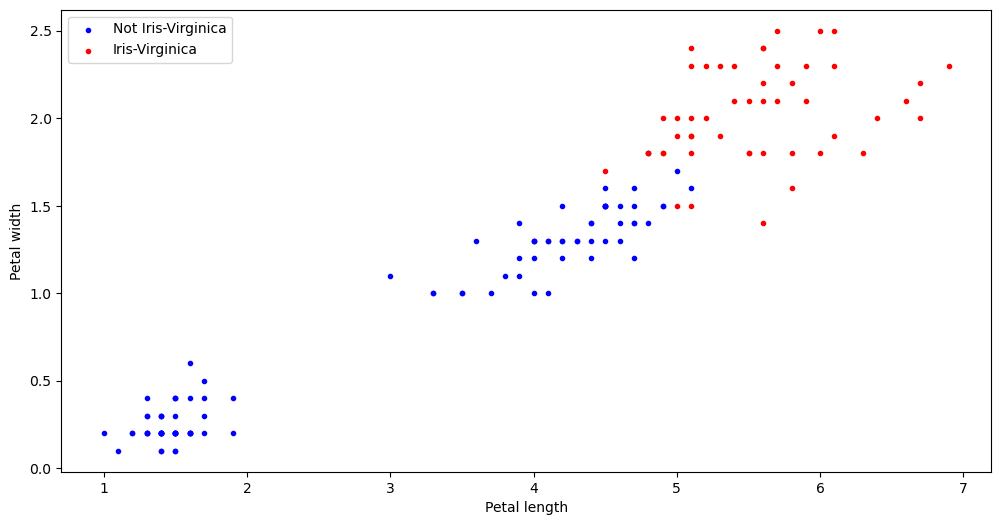

In [107]:
# Graphical representation of the generated dataset
plt.figure(figsize=(12, 6))
plt.scatter(X_iris[:,0][y_iris == 0], X_iris[:,1][y_iris == 0], c="b", marker=".", label="Not Iris-Virginica")
plt.scatter(X_iris[:,0][y_iris == 1], X_iris[:,1][y_iris == 1], c="r", marker=".", label="Iris-Virginica")
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend()
plt.show()


In [108]:
# Train a Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()
clf_nb.fit(X_iris, y_iris)


GaussianNB()

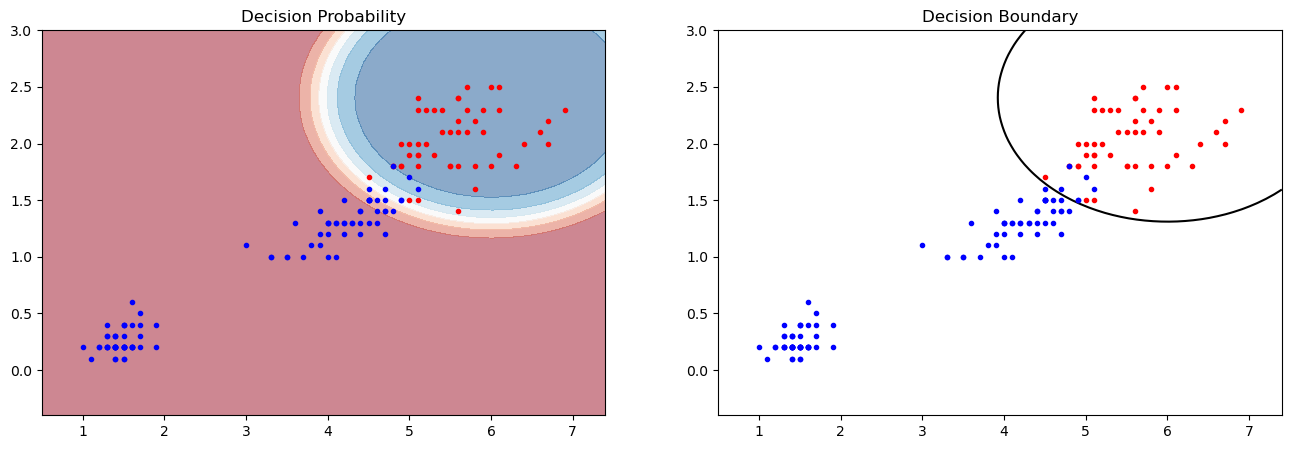

In [109]:
# Decision boundary of Naive Bayes
plt.figure(figsize=(16, 5))
plot_decision_boundary(X_iris, y_iris, clf_nb)
plt.show()


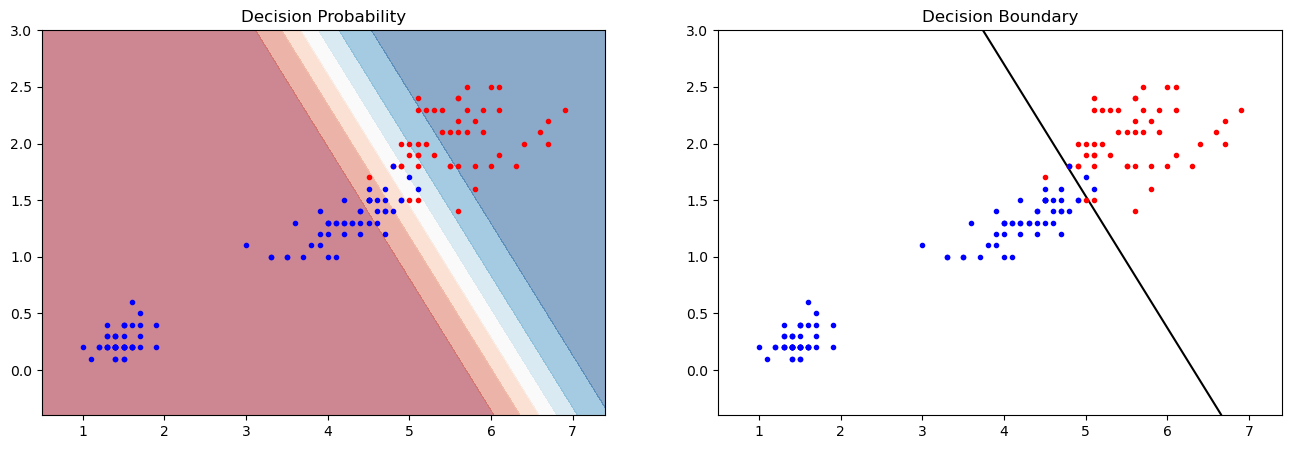

In [110]:
# Decision boundary of Logistic Regression
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
clf_lr.fit(X_iris, y_iris)

plt.figure(figsize=(16,5))
plot_decision_boundary(X_iris, y_iris, clf_lr)
plt.show()


## 7. Conclusion

The Naive Bayes Spam Detection project focused on building a reliable spam classifier using the 2007 TREC Public Spam Corpus, which contains over 75,000 emails. The model achieved an impressive F1 score of 0.969, showing it can effectively balance precision and recall—meaning it’s good at catching spam without too many false alarms.

Key steps like tokenization, HTML stripping, and vectorization were critical for preparing the email data for the Naive Bayes classifier. By processing a large dataset, the model proved it’s not just accurate, but also scalable and resilient enough for real-world spam filtering. This makes it a powerful tool for any organization looking to manage large volumes of email data with ease and precision.